In [1]:
import jax
jax.config.update("jax_enable_x64", True)

from jax import numpy as jnp
from jax import vmap, grad, jit
from jax.scipy.special import sph_harm

import s2fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt




def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)


def normalize(v, vmin=None, vmax=None):
    if vmin is None:
        vmin = jnp.min(v)
    if vmax is None:
        vmax = jnp.max(v)
    return (v - vmin) / (vmax - vmin)

  
def rotY(beta):
    return jnp.array([
        [jnp.cos(beta), 0, jnp.sin(beta)],
        [0, 1, 0],
        [-jnp.sin(beta), 0, jnp.cos(beta)]
    ])


def rotZ(gamma):
    return jnp.array([
        [jnp.cos(gamma), -jnp.sin(gamma), 0],
        [jnp.sin(gamma), jnp.cos(gamma), 0],
        [0, 0, 1]
    ])
    

def rotZYZ(alpha, beta, gamma):
    return rotZ(alpha) @ rotY(beta) @ rotZ(gamma)


def cart2sph(x, y, z):
    r = jnp.sqrt(x**2 + y**2 + z**2)
    theta = jnp.arccos(z/r)
    phi = jnp.arctan2(y, x)
    return theta, phi


def sph2cart(theta, phi, r=1.):
    x = r * jnp.sin(theta) * jnp.cos(phi)
    y = r * jnp.sin(theta) * jnp.sin(phi)
    z = r * jnp.cos(theta)
    return x, y, z


def rot_sph(theta, phi, alpha, beta, gamma):
    x, y, z = sph2cart(theta, phi)
    x, y, z = rot_pt(x, y, z, alpha, beta, gamma)
    return cart2sph(x, y, z)


def rot_pt(x, y, z, alpha, beta, gamma):
    R = rotZYZ(alpha, beta, gamma)
    xyz = (R @ jnp.array([[x, y, z]]).T).squeeze()
    return xyz[0], xyz[1], xyz[2]


def rot_pts(x,y,z, alpha, beta, gamma):
    R = rotZYZ(alpha, beta, gamma)
    xyz = vmap(lambda xi,yi,zi: R @ jnp.array([[xi, yi, zi]]).T)(x, y, z)
    return xyz[:,0], xyz[:,1], xyz[:,2]


def inv_rot_pts(x,y,z, alpha, beta, gamma):
    return rot_pts(x, y, z, -gamma, -beta, -alpha)


def inv_rot_pt(x,y,z,alpha, beta, gamma):
    return rot_pt(x, y, z, -gamma, -beta, -alpha)


def eval_shell(theta, phi, fm, ls, ms, L_max):
    # sph_harm uses different conventions for theta and phi
    theta, phi = phi, theta
    return jnp.sum(sph_harm(ms, ls, jnp.array([theta]), jnp.array([phi]), n_max=L_max) * fm)
    #return jnp.sum(basis(ms) * fm)


def rot_sph_harm(fm, alpha, d_beta, gamma, ms):
    return jnp.exp(-1j*ms*alpha) * jnp.einsum('ij,j->i', d_beta, jnp.exp(-1j*ms*gamma) * fm)


def rot_slice_sph(fm, alpha, d_beta, gamma, ms, sph_zero):
    return rot_sph_harm(fm, alpha, d_beta, gamma, ms) * sph_zero


def get_slicing_weights(betas, ms, L):
    d_beta = vmap(lambda beta: s2fft.utils.rotation.generate_rotate_dls(L, beta)[-1, :, :])(betas)
    sph_zero = sph_harm(ms, jnp.ones_like(ms)*(L-1), 0., jnp.pi/2)
    return d_beta, sph_zero


def random_signal(L, key):
    key1, key2 = jax.random.split(key)
    ms = jnp.arange(-(L-1), (L-1)+1).astype(jnp.int32)
    f = jax.random.normal(key1, shape=(2*L-1)) + 1j * jax.random.normal(key2, shape=(2*L-1))
    f = f + (-1)**(L-1-ms)*jnp.conjugate(f[::-1])
    return f


def plot_sph_parity(f, thetas, phis):
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Re F(r)")
    v = colormap(normalize(f.real))
    plot_sph(v, thetas, phis, ax)
    
    ax = plt.subplot(142, projection='3d')
    plt.title("Re F(-r)")
    v = colormap(normalize(f.real))
    plot_sph(v, jnp.pi - thetas, phis + jnp.pi, ax)

    ax = plt.subplot(143, projection='3d')
    plt.title("Im F(r)")
    v = colormap(normalize(f.imag))
    plot_sph(v, thetas, phis, ax)

    ax = plt.subplot(144, projection='3d')
    plt.title("-Im F(-r)")
    v = colormap(normalize(-f.imag))
    plot_sph(v, jnp.pi - thetas, phis + jnp.pi, ax)
    

def plot_sph(f, theta, phi, ax):
    theta, phi = jnp.meshgrid(theta, phi)
    x, y, z = sph2cart(theta, phi)
    ax.plot_surface(x, y, z, facecolors=f, rstride=1, cstride=1, shade=False)


def plot_rot(alphas, betas, N):
    gammas = jnp.zeros_like(alphas)
    t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]
    x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
    i1, i2 = 0, 5
    
    # Plot sampling points
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(141, projection='3d')
    plt.title("Sampled angles")
    ax.scatter(*sph2cart(betas, alphas, r=1), color='r')
    
    # Scatter rotated pooints for alpha[i], beta[i] rotation
    ax = plt.subplot(142, projection='3d')
    plt.title("Example rotation 1")
    ax.scatter(*rot_pts(x0, y0, z0, alphas[i1], betas[i1], gammas[i1]), color='r')
    ax.plot(*[[0., p] for p in rot_pt(0, 0, 1., alphas[i1], betas[i1], gammas[i1])], color='b')
    
    ax = plt.subplot(143, projection='3d')
    plt.title("Example rotation 2")
    ax.scatter(*rot_pts(x0, y0, z0, alphas[i2], betas[i2], gammas[i2]), color='r')
    ax.plot(*[[0., p] for p in rot_pt(0, 0, 1., alphas[i2], betas[i2], gammas[i2])], color='b')
    
    ax = plt.subplot(144, projection='3d')
    plt.title("Coverage")
    for i in range(len(alphas)):
        ax.scatter(*rot_pts(x0, y0, z0, alphas[i], betas[i], gammas[i]), color='b')
    ax.scatter(*sph2cart(betas, alphas, r=1), color='r')
    ax.view_init(elev=0, azim=90)



In [2]:
# Indices
L =11
ms = jnp.arange(-(L-1), (L-1)+1)#.astype(jnp.int32)
ls = jnp.ones_like(ms)*(L-1)
eval_shell_wrap = lambda thetas, phis, fm: eval_shell(thetas, phis, fm, ls, ms, L)

# Eval grid
thetas = jnp.linspace(0, jnp.pi, 50)
phis = jnp.linspace(0, 2*jnp.pi, 101)#[:-1]
Theta, Phi = jnp.meshgrid(thetas, phis)

# Signal
fm = random_signal(L, jax.random.PRNGKey(0))
f = vmap(vmap(lambda theta, phi: eval_shell(theta, phi, fm, ls, ms, L), (0, None)), (None, 0))(thetas, phis)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


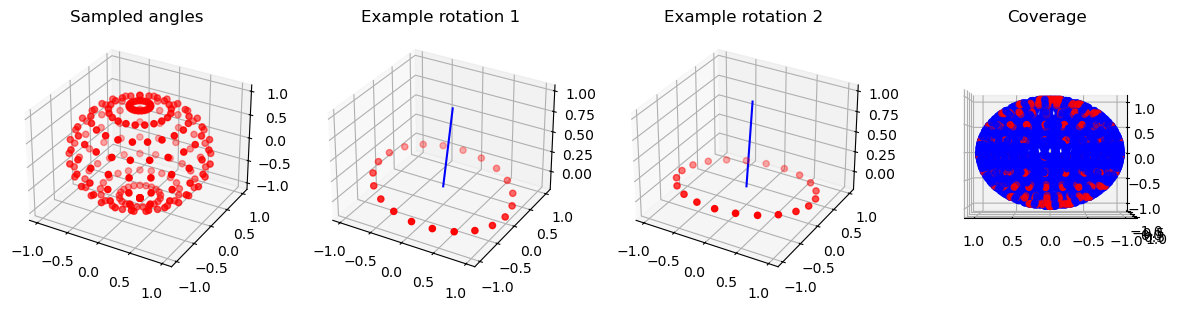

In [3]:
sampling, Lmax = "mw", L
alphas = s2fft.sampling.s2_samples.phis_equiang(Lmax, sampling)
betas = s2fft.sampling.s2_samples.thetas(Lmax, sampling)

Alphas, Betas = jnp.meshgrid(alphas, betas)
Alphas, Betas = Alphas.flatten(), Betas.flatten()
Gammas = jnp.zeros_like(Alphas)
plot_rot(Alphas, Betas, (2*L-1))

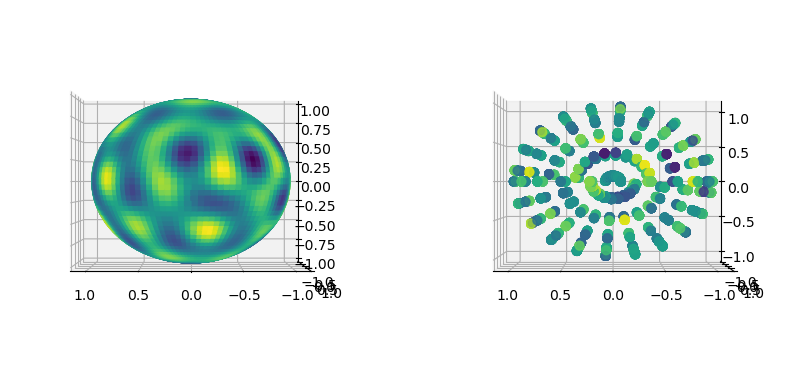

In [24]:
f = jit(vmap(vmap(eval_shell_wrap, (0, None, None)), (None, 0, None)))(thetas, phis, fm).real
v = colormap(normalize(f))
vmax, vmin = jnp.max(f), jnp.min(f)


def get_corr(afft, bfft):
    return jnp.fft.ifft(afft * jnp.conj(bfft))


def ifft_shifted(f):
    #fi = vmap(lambda t: jnp.sum(fm_rot_slices[i] * jnp.exp(1j*t*ms)))(t).real
    return jnp.fft.ifft(jnp.fft.ifftshift(f)) * len(f)
    

def fft_shifted(f):
    return jnp.fft.fftshift(jnp.fft.fft(f))


d_betas, sph_zeros = get_slicing_weights(Betas, ms, L)
fm_rot_slices = vmap(rot_slice_sph, (None, 0, 0, 0, None, None))(fm, Alphas, d_betas, Gammas, ms, sph_zeros)


plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121, projection='3d')
plot_sph(v, thetas, phis, ax1)

ax2 = plt.subplot(122, projection='3d')
r = 1.01
t = jnp.linspace(0, 2*jnp.pi, len(fm_rot_slices[0])+1)[:-1]
x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
for i in range(len(Alphas)):
    alpha, beta, gamma = Alphas[i], Betas[i], Gammas[i]
    fi = ifft_shifted(fm_rot_slices[i]).real
    c = colormap(normalize(fi, vmin, vmax))
    x, y, z = inv_rot_pts(x0, y0, z0, alpha, beta, gamma)
    ax2.scatter(x*r, y*r, z*r, s=40, color=c)
#plot_sph(v, thetas, phis, ax2)


elev, azim = 0, 90
for ax in [ax1, ax2]:
    ax.view_init(elev=elev, azim=azim)



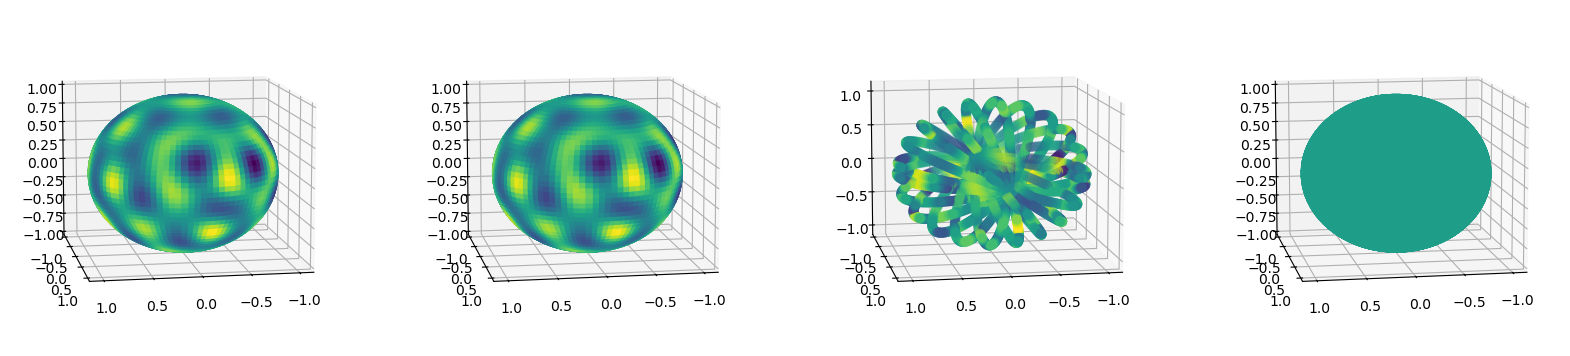

In [5]:
def f_dom_rot(alpha, beta, gamma):
    return lambda thetas, phis: eval_shell_wrap(*rot_sph(thetas, phis, alpha, beta, gamma), fm)

def f_wig_rot(alpha, d_beta, gamma):
    fm_rot = rot_sph_harm(fm, alpha, d_beta, gamma, ms)
    return lambda thetas, phis: eval_shell_wrap(thetas, phis, fm_rot)

def f_slice(fm, alpha, d_beta, gamma, sph_zero):
    return rot_slice_sph(fm, alpha, d_beta, gamma, ms, sph_zero)



d_betas, sph_zeros = get_slicing_weights(Betas, ms, L)
fm_rots = vmap(rot_sph_harm, (None, 0, 0, 0, None))(fm, Alphas, d_betas, Gammas, ms)
fm_rot_slices = vmap(f_slice, (None, 0, 0, 0, None))(fm, Alphas, d_betas, Gammas, sph_zeros)

idx = 4
alpha, beta, gamma, d_beta = 0., 0., 0., jnp.eye(2*L-1) #Alphas[idx], Betas[idx], 0.0, d_betas[idx] #0.3, 0.5*jnp.pi*2, 0.0
fm_rot = fm_rots[idx]

f_dom_rot_eval = jit(vmap(vmap(f_dom_rot(-gamma, -beta, -alpha), (0, None)), (None, 0)))(thetas, phis).real
#f_wig_rot_eval = jit(vmap(vmap(eval_shell_wrap, (0, None, None)), (None, 0, None)))(thetas, phis, fm_rot).real
f_wig_rot_eval = vmap(vmap(f_wig_rot(alpha, d_beta, gamma), (0, None)), (None, 0))(thetas, phis).real

v_dom = colormap(normalize(f_dom_rot_eval))
v_wig = colormap(normalize(f_wig_rot_eval))
vmax, vmin = jnp.max(f_dom_rot_eval), jnp.min(f_dom_rot_eval)
v_diff = colormap(normalize(f_dom_rot_eval - f_wig_rot_eval, vmin, vmax))

elev, azim = 10, 80
plt.figure(figsize=(20, 5))
plot_sph(v_dom, thetas, phis, plt.subplot(141, projection='3d'))
plt.gca().view_init(elev=elev, azim=azim)
plot_sph(v_wig, thetas, phis, plt.subplot(142, projection='3d'))
plt.gca().view_init(elev=elev, azim=azim)

ax = plt.subplot(143, projection='3d')

t = jnp.linspace(0, 2*jnp.pi, L)[:-1]
x0, y0, z0 = jnp.cos(t), jnp.sin(t), jnp.zeros_like(t)
for i in range(len(Alphas)):
    alpha, beta, gamma = Alphas[i], Betas[i], Gammas[i]
    sph_slice_ifft = vmap(lambda t: jnp.sum(fm_rot_slices[i] * jnp.exp(1j*t*ms)))(t).real
    c = colormap(normalize(sph_slice_ifft, vmin, vmax))

    x, y, z = inv_rot_pts(x0, y0, z0, alpha, beta, gamma)
    ax.scatter(x, y, z, s=40, color=c)
ax.view_init(elev=elev, azim=azim)

plot_sph(v_diff, thetas, phis, plt.subplot(144, projection='3d'))
plt.gca().view_init(elev=elev, azim=azim)


In [6]:
#
# Angle recovery
#   # Step 0: Precompute Wigner-D matrices and Great Circle Fourier Coefficients
        # Step 0a: Precompute Wigner-D matrices
            # wigner_D = vmap(s2fft.recursion_etc)(alphas, betas)
        # Step 0b: Precompute Great Circle Fourier Coefficients
    # Step 1: Iterate over alpha, beta
        # Step 1a: compute optimal plane rot phi, and correlation c
        # phi_max, corr_max = vmap(lambda alpha, beta: opt_rot(alpha, beta, fm, data))(alphas, betas)
            # step 1aa: rotate fm by alpha, beta using wigner-D (PRECOMPUTE: step 0)
            # step 1ab: extract fourier coefficients of rotated signal at great circle (PRECOMPUTE: step 0)
            # step 1ac: compute correlation between rotated signal and data
            # corr(afft,bfft) = ifft(afft*conj(bfft))
            # cval = corr(data_fft, slice(alpha, beta, flm))  ### Big question: Why is this the correlation??? Real vs Complex space
            # idmax = argmax(cval)
            # return phi[idmax], cval[idmax]
            
    # Step 3: Extract alpha_max, beta_max, phi_max
    
    # argmax -> alpha_max, beta_max, phi_max
    
# Averaging
# 